In [393]:
import sys, os
sys.path.append('../..')

import logging
import numpy as np
import matplotlib.pyplot as plt

from simulation_new.lensing_sim import LensingSim
from simulation_new.units import *
from astropy.cosmology import Planck15

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [394]:
M_MW = 1.1e12*M_s
m_0 = 1e9*M_s
beta = 1.9

In [395]:
def alpha_calib(m_min_calib, m_max_calib, n_calib, M_calib, beta):
    return -M_MW * (m_max_calib * m_min_calib / m_0) ** beta * n_calib * (-1 + beta) / \
        ( M_calib * ( -m_max_calib ** beta * m_min_calib + m_max_calib * m_min_calib ** beta))

In [396]:
alpha = alpha_calib(1e8*M_s, 1e10*M_s, 150, M_MW, beta)

In [397]:
def n_sub(m_min, m_max, M):
    return alpha * M * (m_max * m_min / m_0) ** -beta * (m_max ** beta * m_min - m_max * m_min ** beta) / (M_MW * ( -1 + beta))


In [398]:
def c200_SCP(M200):
    """ Concentration-mass relation according to eq. 1 of  Sanchez-Conde & Prada 2014 (1312.1729)
        :param M200: M200 mass of subhalo
    """
    x=np.log(M200/(M_s/h))
    pars=[37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7][::-1]
    return np.polyval(pars, x)

In [422]:
M_hst = 1e14*M_s
c_hst = c200_SCP(M_hst)
m_min = 1e9*M_s
n_sub_tot = n_sub(m_min, 0.01*M_hst, M_hst)

In [423]:
def get_rs_rhos_NFW(M200, c200):
    """ Get NFW scale radius and density
    """
    r200 = (M200/(4/3.*np.pi*200*rho_c))**(1/3.)
    rho_s = M200/(4*np.pi*(r200/c200)**3*(np.log(1 + c200) - c200/(1 + c200)))
    r_s = r200/c200
    return r_s, rho_s

In [424]:
r_s, rho_s = get_rs_rhos_NFW(M_hst, c_hst)

In [425]:
def Sigma_cr(D_l, D_s):
    """ Critical surface density
    """
    return 1.0 / (4 * np.pi * GN) * D_s / ((D_s - D_l) * D_l)


In [426]:
def F(x):
    """ Helper function for NFW deflection, from astro-ph/0102341
    """
    if x > 1:
        return np.arctan(np.sqrt(x ** 2 - 1)) / (np.sqrt(x ** 2 - 1))
    elif x == 1:
        return 1
    elif x < 1:
        return np.arctanh(np.sqrt(1 - x ** 2)) / (np.sqrt(1 - x ** 2))


In [427]:
z_s = 1.5
z_l = 0.5

D_s = Planck15.angular_diameter_distance(z=z_s).value * Mpc
D_l = Planck15.angular_diameter_distance(z=z_l).value * Mpc

Scr = Sigma_cr(D_l, D_s)

In [428]:
def M_enc(x):
    return np.log(x/2) + F(x)

In [429]:
4/64

0.0625

In [430]:
theta_s = (r_s / D_l) 

In [431]:
r_roi = 2.5
f_sub = M_enc(r_roi * asctorad / theta_s) / M_enc(c_hst * theta_s / theta_s)

In [432]:
n_sub_roi = np.random.poisson(f_sub * n_sub_tot)
print(n_sub_roi)

14


3504.8420702100093


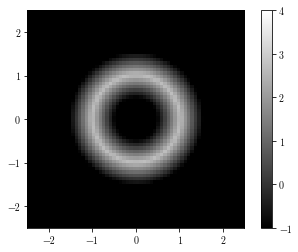

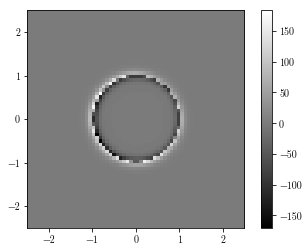

In [469]:
def _draw_m_sub(n_sub, m_sub_min, beta):
    u = np.random.uniform(0, 1, size=n_sub)
    m_sub = m_sub_min * (1 - u) ** (1.0 / (beta + 1.0))
    return m_sub

m_sub = _draw_m_sub(n_sub_roi, m_min, -beta)

# print(m_sub/M_s)
coordinate_limit = 2.5
exposure = 2000 #(1 / 1.8e-19) * erg ** -1 * Centimeter ** 2 * Angstrom * 1000 * Sec
# exposure = 6.1e18 * erg ** -1 * Centimeter ** 2 * Angstrom * 1000 * Sec

A_iso = 0 # 2e-7 * erg / Centimeter ** 2 / Sec / Angstrom / (radtoasc) ** 2

hst_param_dict = {
            "profile": "SIE",
            "theta_x_0": 0.0,
            "theta_y_0": 0.0,
            "theta_E": 1,
            "q": 1.,
}

lens_list = [hst_param_dict]

for m in m_sub:
    c = c200_SCP(m)
    r_s, rho_s = get_rs_rhos_NFW(m, c)
    sub_param_dict = {
                "profile": "NFW",
                "theta_x_0": np.random.uniform(-2,2),
                "theta_y_0": np.random.uniform(-2,2),
                "M_200": m,
                "r_s": r_s,
                "rho_s": rho_s
    }

    lens_list.append(sub_param_dict)


observation_dict = {
            "n_x": 64,
            "n_y": 64,
            "theta_x_lims": (-coordinate_limit, coordinate_limit),
            "theta_y_lims": (-coordinate_limit, coordinate_limit),
            "exposure": exposure,
            "f_iso": A_iso,
        }

src_param_dict = {
            "profile": "Sersic",
            "theta_x_0": .01,
            "theta_y_0": .01,
            "S_tot": 1,
            "theta_e": 0.1,
            "n_srsc": 1,
        }

global_dict = {"z_s": z_s, "z_l": z_l}

lsi = LensingSim(lens_list, 
                 [src_param_dict], 
                 global_dict, 
                 observation_dict)

image = (lsi.lensed_image())

v_min = -1
v_max = 4.

plt.imshow(np.log10(image),
        vmin=v_min,
        vmax=v_max,
        cmap='gist_gray',
        extent=(-coordinate_limit, coordinate_limit,-coordinate_limit, coordinate_limit),
        origin="lower"
)
plt.colorbar()

lsi = LensingSim([lens_list[0]], 
                 [src_param_dict], 
                 global_dict, 
                 observation_dict)

image_hst = (lsi.lensed_image())

v_min = -1
v_max = 4.

plt.figure()

plt.imshow((image-image_hst),
        cmap='gist_gray',
        extent=(-coordinate_limit, coordinate_limit,-coordinate_limit, coordinate_limit),
        origin="lower"
)
plt.colorbar()

print(np.sum(image-image_hst))

In [434]:
# Mapping mass to velocity dispersion
4
a = 0.09
b = 3.48

def Msv(sigma_v):
    """ https://arxiv.org/pdf/1804.04492.pdf
    """
    l10m = a + b * np.log10(sigma_v / (100*Kmps))
    sigma_l10m = 0.13
    l10m = np.random.normal(l10m, sigma_l10m)
    return (10**l10m)*1e12*M_s

print(np.log10(Msv(250*Kmps)/M_s))

13.501877802636704


In [412]:
mag_zp = 25.5
n_srsc = 1
reff = 0.1

from scipy.special import gamma

def kappa(n):
    """
    Sersic profile exponential scaling factor, called either kappa or b_n
    Uses analytic expansion from Ciotti & Bertin 1999, A&A, 352, 447
    """
    return (2*n - 1/3 + 4/405*n**-1 + 46/25515*n**-2 + 131/1148175*n**-3
            - 2194697/30690717750*n**-4)

def sb_eff_adu(mag, mag_zp):
    """
    Returns the surface brightness (in flux units per pixel) at re
    """
    bn = kappa(n_srsc)
    flux_tot = total_flux_adu(mag, mag_zp)
    return flux_tot / (np.pi * reff ** 2 * 2*n_srsc *
                       np.exp(bn + np.log(bn) * -2*n_srsc) *
                       gamma(2*n_srsc))

def total_flux_adu(mag, mag_zp):
    """
    Returns total flux of the integrated profile, in ADU relative to mag_zp
    """
    return 10**(-0.4 * (mag - mag_zp))


In [232]:
sb_eff_adu(25, 25.5)

13.264481269311071

In [220]:
total_flux_adu(25, 25.5)

1.5848931924611136

Makes sense!